# Classifying microbiomes using machine learning

***

This experiment can be performed using [BANNER](https://github.com/will-rowe/banner). I have just separated out the code into a notebook for the purposes of plotting and documenting the steps.

## Commands used to generate the sketches

``` bash
```

## Command used to generate feature matrix from the sketches

* Label the sketches from non-antibiotic treated samples as 0

```
hulk smash --bannerMatrix -d ./no-abx-sketches -o no-abx -l 0
```

* Label the sketches from antibiotic treated samples as 1

```
hulk smash --bannerMatrix -d ./abx-sketches -o abx -l 1
```

* Combine into a feature set file, which we will use for this analysis

```
cat no-abx.bannerMatrix.csv abx.bannerMatrix.csv > rcf-features.csv
```

In [3]:
# Imports
import os
import sys
import time
import argparse
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.cross_validation import cross_val_score
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('fivethirtyeight')

In [5]:
# Load the feature data (bannerMatrix from HULK)
data = np.loadtxt(fname = "data/3.rfc/rfc-features.csv", delimiter = ',', dtype = int)

In [6]:
# Split into features and labels
## HULK adds the label to the final column of the bannerMatrix
## 0 = no-abx, 1 = abx
features = data[:, :-1]
labels = data[:, -1]

In [7]:
# Split data into training and testing (test size = 20%)
total_test_size = int(len(features) * 0.2)
np.random.seed(2)
indices = np.random.permutation(len(features))
trainFeatures = features[indices[:-total_test_size]]
trainLabels = labels[indices[:-total_test_size]]
testFeatures  = features[indices[-total_test_size:]]
testLabels  = labels[indices[-total_test_size:]]

In [8]:
# Generate the classifier
rfc = RandomForestClassifier(bootstrap=True, class_weight=None, n_estimators=1000, n_jobs=1)

In [9]:
# Train
rfc.fit(trainFeatures, trainLabels)
trainPredictions = rfc.predict(trainFeatures)
print("train accuracy: {}".format((accuracy_score(trainLabels, trainPredictions))))

train accuracy: 1.0


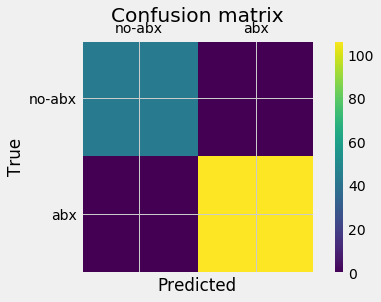

In [10]:
# Generate confusion matrix for training
def printCM(trainLabels, trainPredictions):
    labels = ['no-abx', 'abx']
    cm = confusion_matrix(trainLabels, trainPredictions)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

printCM(trainLabels, trainPredictions)

In [11]:
# Perform 10-fold cross validation for training
crossValidation = cross_val_score(rfc, trainFeatures, trainLabels, cv=10, scoring='f1_weighted', n_jobs=1)
print("cross validation accuracy (mean): {}" .format(np.mean(crossValidation)))
print("cross validation accuracy (st.d.): {}" .format(np.std(crossValidation)))

cross validation accuracy (mean): 0.9605877616747183
cross validation accuracy (st.d.): 0.04269379688795062


In [12]:
# Test the RFC
testPredictions = rfc.predict(testFeatures)
print("f1 score: {}" .format(f1_score(testLabels, testPredictions, average="macro")))
print("precision: {}" .format(precision_score(testLabels, testPredictions, average="macro")))
print("recall score: {}" .format(recall_score(testLabels, testPredictions, average="macro")))
print("test accuracy: {}" .format(accuracy_score(testLabels, testPredictions)))

f1 score: 0.9202586206896552
precision: 0.9666666666666667
recall score: 0.8888888888888888
test accuracy: 0.9459459459459459


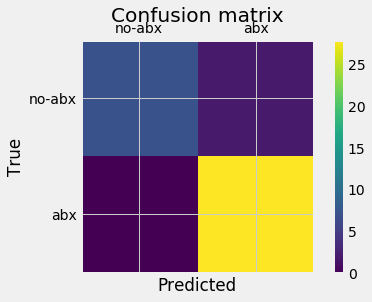

In [13]:
# Generate confusion matrix
printCM(testLabels, testPredictions)

In [14]:
# Assess feature importance
importances = list(rfc.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(trainFeatures, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)